# EDA – Labeled Dataset Analysis

Exploratory analysis of the manually labeled Sukuk financial-document pages stored in `mini_labels.csv`.  
The goal is to understand class distribution, per-PDF breakdowns, and dataset balance before any modeling work.

## 1 — Load Data

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
})

CSV_PATH = "mini_labels.csv"

df = pd.read_csv(CSV_PATH)
df.head()

,image_name,label
0,FS1_page_1.jpg,Other Pages
1,FS1_page_2.jpg,Other Pages
2,FS1_page_3.jpg,Independent Auditor's Report
3,FS1_page_4.jpg,Independent Auditor's Report
4,FS1_page_5.jpg,Independent Auditor's Report


## 2 — Dataset Overview

In [2]:
total_images = len(df)
unique_classes = df["label"].nunique()
class_names = df["label"].unique().tolist()

print(f"Total labeled images : {total_images}")
print(f"Unique classes       : {unique_classes}")
print(f"Class names          : {class_names}")
print()
print(df["label"].value_counts())

Total labeled images : 174
Unique classes       : 5
Class names          : ['Other Pages', "Independent Auditor's Report", 'Financial Sheets', 'Notes (Text)', 'Notes (Tabular)']

label
Notes (Tabular)                 81
Notes (Text)                    45
Financial Sheets                21
Independent Auditor's Report    17
Other Pages                     10
Name: count, dtype: int64


## 3 — Class Distribution

In [3]:
class_counts = df["label"].value_counts()
class_pct = df["label"].value_counts(normalize=True).mul(100).round(1)

dist_table = pd.DataFrame({
    "Class Name": class_counts.index,
    "Count": class_counts.values,
    "Percentage (%)": class_pct.values,
})
dist_table.index = range(1, len(dist_table) + 1)
dist_table.index.name = "#"
dist_table

,Class Name,Count,Percentage (%)
#,,,
1,Notes (Tabular),81,46.6
2,Notes (Text),45,25.9
3,Financial Sheets,21,12.1
4,Independent Auditor's Report,17,9.8
5,Other Pages,10,5.7


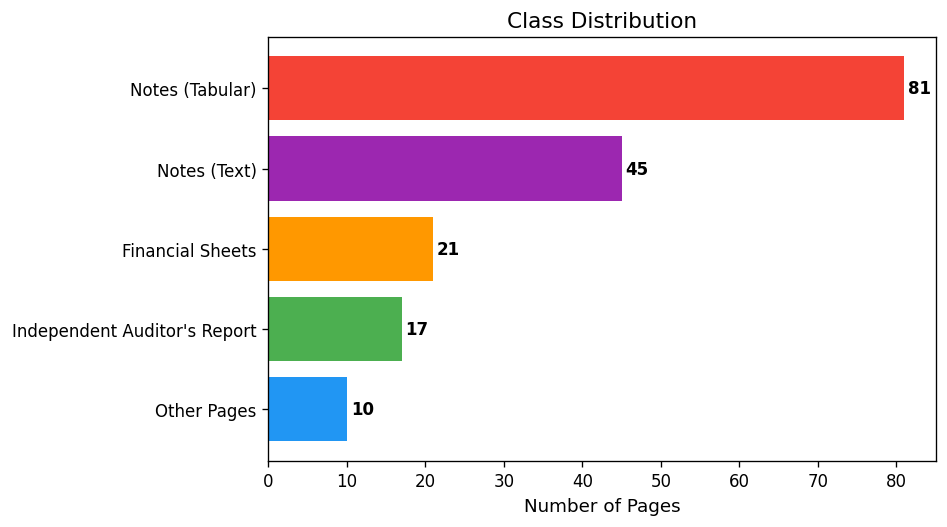

In [4]:
colors = ["#2196F3", "#4CAF50", "#FF9800", "#9C27B0", "#F44336"]

fig, ax = plt.subplots(figsize=(8, 4.5))
bars = ax.barh(class_counts.index[::-1], class_counts.values[::-1], color=colors[:len(class_counts)])

for bar, count in zip(bars, class_counts.values[::-1]):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
            str(count), va="center", fontsize=10, fontweight="bold")

ax.set_xlabel("Number of Pages")
ax.set_title("Class Distribution")
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

## 4 — PDF-Level Distribution

In [5]:
df["pdf_prefix"] = df["image_name"].apply(lambda x: re.match(r"^(.+?)_page_", x).group(1))

pdf_counts = df["pdf_prefix"].value_counts().sort_index(
    key=lambda idx: idx.map(lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split(r"(\d+)", s)])
)

pdf_table = pd.DataFrame({
    "PDF Prefix": pdf_counts.index,
    "Pages": pdf_counts.values,
})
pdf_table.index = range(1, len(pdf_table) + 1)
pdf_table.index.name = "#"
pdf_table

,PDF Prefix,Pages
#,,
1,FS1,33
2,FS2,41
3,FS3,33
4,FS4,28
5,FS5,39


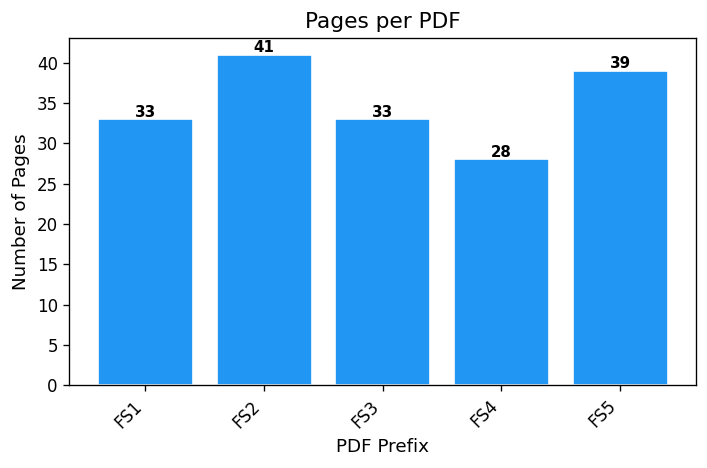

In [6]:
fig, ax = plt.subplots(figsize=(max(6, len(pdf_counts) * 0.8), 4))
ax.bar(pdf_counts.index, pdf_counts.values, color="#2196F3", edgecolor="white")

for i, (prefix, count) in enumerate(pdf_counts.items()):
    ax.text(i, count + 0.3, str(count), ha="center", fontsize=9, fontweight="bold")

ax.set_xlabel("PDF Prefix")
ax.set_ylabel("Number of Pages")
ax.set_title("Pages per PDF")
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [7]:
cross = pd.crosstab(df["pdf_prefix"], df["label"])
cross = cross.reindex(
    sorted(cross.index, key=lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split(r"(\d+)", s)])
)
cross

label,Financial Sheets,Independent Auditor's Report,Notes (Tabular),Notes (Text),Other Pages
pdf_prefix,,,,,
FS1,4,3,14,10,2
FS2,4,4,20,11,2
FS3,5,3,17,6,2
FS4,4,3,9,10,2
FS5,4,4,21,8,2


## 5 — Imbalance Analysis

In [8]:
largest_class = class_counts.idxmax()
smallest_class = class_counts.idxmin()
imbalance_ratio = class_counts.max() / class_counts.min()

print(f"Largest class  : {largest_class}  ({class_counts.max()} samples)")
print(f"Smallest class : {smallest_class}  ({class_counts.min()} samples)")
print(f"Imbalance ratio: {imbalance_ratio:.2f}x")

Largest class  : Notes (Tabular)  (81 samples)
Smallest class : Other Pages  (10 samples)
Imbalance ratio: 8.10x


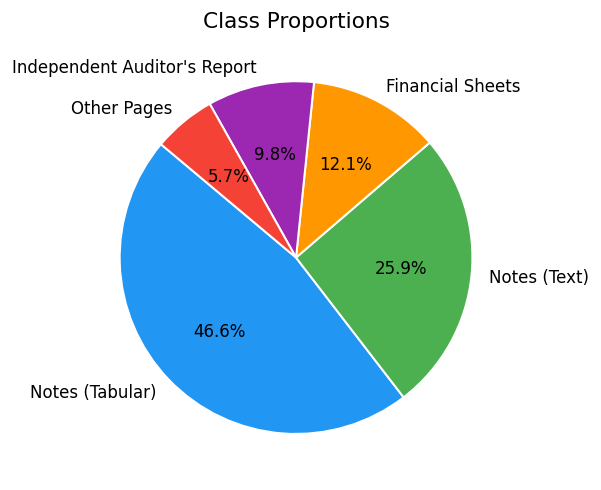

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    class_counts.values,
    labels=class_counts.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=colors[:len(class_counts)],
    wedgeprops={"edgecolor": "white", "linewidth": 1.2},
)
ax.set_title("Class Proportions")
plt.tight_layout()
plt.show()

## 6 — Summary

**Key observations:**

- The dataset contains labeled page images from multiple Sukuk financial-document PDFs.
- **Notes (Tabular)** and **Notes (Text)** dominate the dataset, which is expected since financial reports allocate the majority of pages to explanatory notes.
- **Independent Auditor’s Report**, **Financial Sheets**, and **Other Pages** each represent a smaller share, consistent with their shorter sections in the original documents.
- The imbalance ratio between the largest and smallest class should be taken into account when designing any downstream classification pipeline (e.g., stratified splits, class weights, or oversampling).
- PDF-level distributions are relatively consistent across documents, indicating the labeling is coherent and the document structures are similar.